# Восстановление данных дохода

## Описание данных

Вам представлены данные о доходах сотрудников участка горячего проката за год, в том числе данные, описывающие специфику рабочих мест.
Доход состоит из оклада, премии, доплат и индивидуальных надбавок. Данных об их размерах не приводится, так как именно их Вам предстоит восстановить.

## Задание 

* Выявите формулу дохода в целом и его составных частей.
* Проверьте, что данная формула объясняет доход с точностью до рубля.
* Выявите зависимости между составными частями дохода.

# Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

In [2]:
pd.options.display.float_format = '{:0.3f}'.format

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,
              rc={"lines.linewidth": 1.25})

plt.rcParams.update({"grid.linewidth":0.5,
                     "grid.alpha":0.5,
                     "figure.figsize": (8, 5)})

%config InlineBackend.figure_format = 'retina'

Прочтем файл, сразу определим столбец "Месяц" как тип относящийся к времени и датам.

In [3]:
df = pd.read_excel('Задание 5.0 2 версия.xlsx', parse_dates=['Месяц'])
df.head(5)

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.412
4,Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.471


Поменяем названия столбцов.

In [4]:
df.columns = ['fio', 'date', 'job', 'rank', 'equipment', 'hazard', 'prod_level', 'income']

# Анализ

Посмотрим как соотносятся зарплаты по месяцам по разным работам.

> Зарплата по месяцам показывает схожую динамику.

In [5]:
df_view = pd.DataFrame()

for job in df.job.unique():
    df_view = pd.concat([df_view, df.query('job == @job').iloc[:12,:]], ignore_index=True)

df_view.shape

(108, 8)

Для всех профессий одинаковый объем производства по месяцам. Это облегчает нашу задачу.

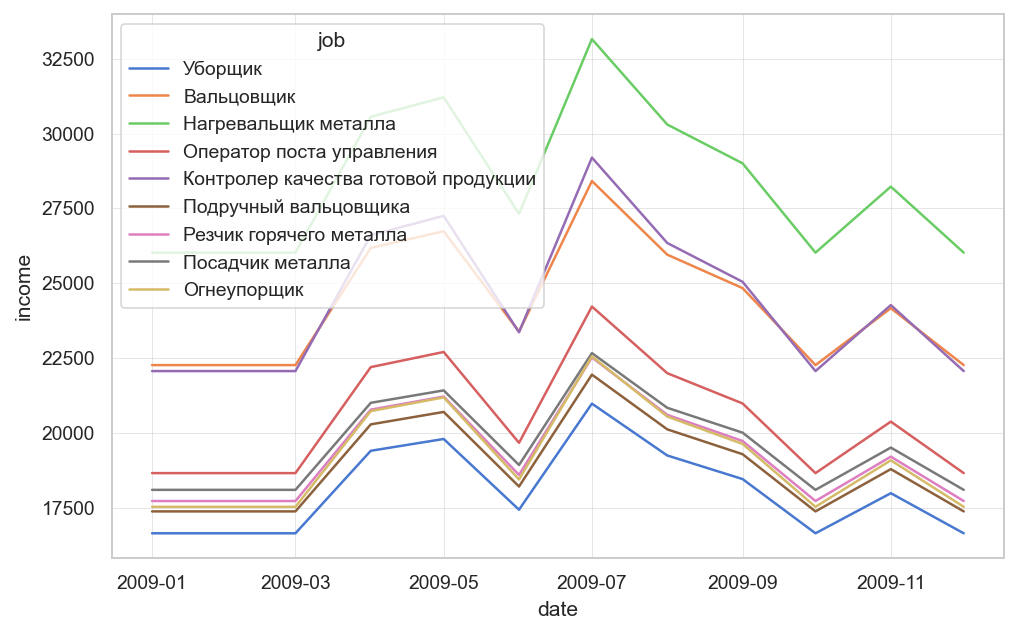

In [6]:
ax = sns.lineplot(data=df_view,
                  x='date', y='income', hue='job',
)

plt.show()

Уникальные значения в rank и hazard.

In [7]:
df['rank'].unique()

array([3, 6, 7, 5, 4], dtype=int64)

In [8]:
df['hazard'].unique()

array([18, 22,  8,  0, 16, 11], dtype=int64)

Сгруппируем данные по Оборудованию, Профессии, Разряду и Вредности.

Нас интересуют только минимальные оклады без привязки к ФИО и времени.

In [9]:
df_view = df.query('date.dt.month == 1').drop(columns = ['fio', 'date', 'prod_level'])
df_view = df_view.groupby(['equipment','job','rank','hazard']).agg('min').reset_index()
df_view.sort_values(['job','rank','hazard'])

,equipment,job,rank,hazard,income
1,Калибровочный стан,Вальцовщик,5,18,19630.000
13,Пилигримовые станы,Вальцовщик,6,18,22260.000
19,Прошивной стан,Вальцовщик,6,18,22260.000
14,Пилигримовые станы,Вальцовщик,7,18,25300.000
20,Прошивной стан,Вальцовщик,7,18,25300.000
5,Контрольно-измерительная аппаратура,Контролер качества готовой продукции,7,0,22060.000
6,Нагревательные печи,Нагревальщик металла,4,22,18090.000
11,"Нагревательные печи, кантовка",Нагревальщик металла,5,22,20350.000
12,"Нагревательные печи, нагрев",Нагревальщик металла,5,22,20350.000
7,Нагревательные печи,Нагревальщик металла,6,22,22980.000


Из таблицы видно, что equipment не оказывает влияние на оклад.

hazard показывает идеальную. линейную взаимосвязь, в то время как у rank присутствует нелинейность.

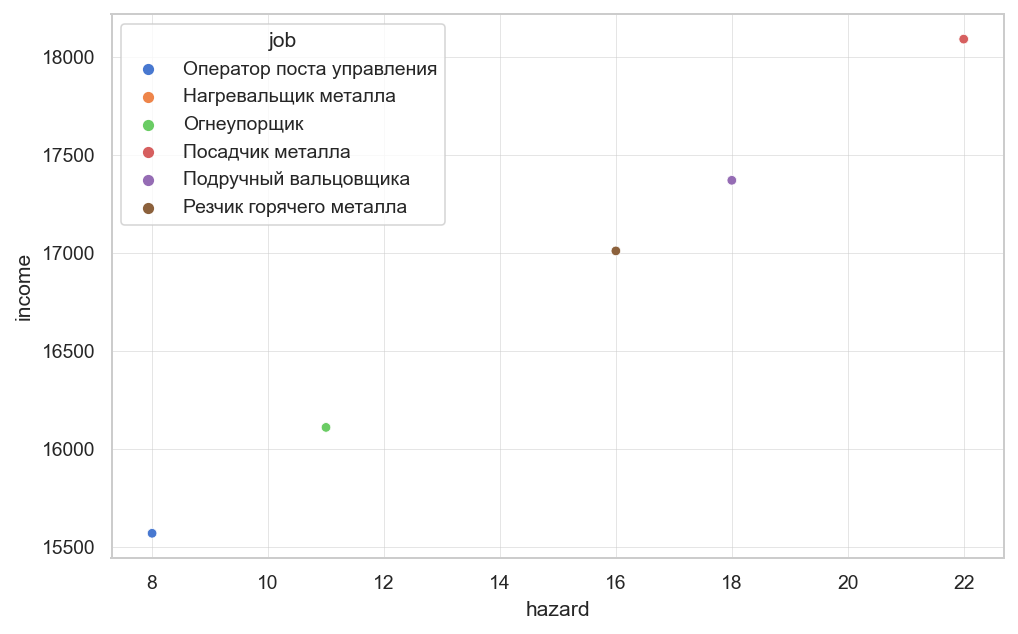

In [10]:
sns.scatterplot(data=df_view.query('rank == 4'),
                x='hazard',
                y='income',
                hue='job');

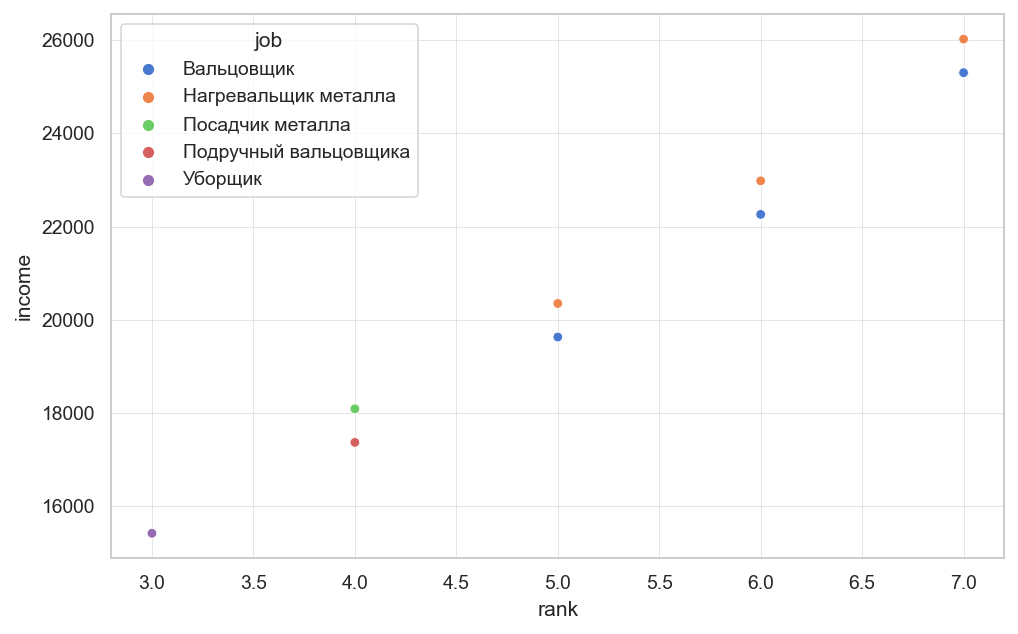

In [11]:
sns.scatterplot(data=df_view.query('hazard == 18 or hazard == 22'),
                x='rank',
                y='income',
                hue='job');

> Мы получили формулу линейной зависимости для hazard и то как соотносятся оклады для разных rank.

In [12]:
income_before_hazard = []
ranks = sorted(df_view['rank'].unique())

for i in ranks:
    lin_hazard = linregress(df_view.query('rank == @i')['hazard'],
                          df_view.query('rank == @i')['income'])
    
    if income_before_hazard != []:
        print(f'Отношение дохода для разных разрядов: {lin_hazard.intercept / income_before_hazard[-1]:.3f}' )
    income_before_hazard.append(round(lin_hazard.intercept))
    
    print(f'Rank: {i}, slope: {lin_hazard.slope:.3f}, intercept: {lin_hazard.intercept:.3f}', '\n')

Rank: 3, slope: 180.000, intercept: 12180.000 

Отношение дохода для разных разрядов: 1.160
Rank: 4, slope: 180.000, intercept: 14130.000 

Отношение дохода для разных разрядов: 1.160
Rank: 5, slope: 180.000, intercept: 16390.000 

Отношение дохода для разных разрядов: 1.160
Rank: 6, slope: 180.000, intercept: 19020.000 

Отношение дохода для разных разрядов: 1.160
Rank: 7, slope: 180.000, intercept: 22060.000 



Так как в условии задачи не указаны средства депремирования сотрудников, то минимальный доход, полученный в месяц в течение года - базовый оклад сотрудника.

In [13]:
base_income = min(df.iloc[:12,-1])
base_income

16638.0

Предположим, что доход полученный в апреле, мае и ноябре несет в себе доплату за продуктивность.

Тогда найдем базовую продуктивность. Она для всех специалистов одинаковая.

In [14]:
delta = df.iloc[4,-2] - df.iloc[0,-2]
overtime = (df.iloc[4,-1] - df.iloc[3,-1]) / (df.iloc[4,-2] - df.iloc[3,-2])
base_prod_level = df.iloc[0,-2] \
                + round(( df.iloc[0,-1] - (df.iloc[4,-1] - overtime * delta) ) / overtime)

print(f'Базовая продуктивность: {base_prod_level}')

Базовая продуктивность: 850


# Составление формулы

Рассчитаем базовую ставку для условно 1 разряда.

In [15]:
base = np.round_(16390 * 1.16**(-5), 0)

Объем производства влияет на оклад, когда он превышает 850 ед.

Чтобы найти k нужно отнять прибавку hazard от окладов. Данный коэффициент говорит о том, как растет оклад на 1 ед. переработки.

In [16]:
k = ((df.loc[4, 'income'] - 180*18) / (df.loc[0, 'income'] - 180*18) - 1) / 400
k

0.0005882352941176522

Итоговая формула будет иметь вид:

In [17]:
rank = 3
hazard = 18
prod_level = 1200
premium = 16638 - np.round_(base * 1.16**rank + 180*hazard, 0)

np.round_((base * 1.16**rank + premium)  * (1 + k * (prod_level - 850) * (prod_level - 850 > 0)) + 180*hazard, 1)

19396.0

In [18]:
df.head(4)

,fio,date,job,rank,equipment,hazard,prod_level,income
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.412


# Валидация

Для начала создадим вспомогательный датафрейм с минимальными окладами за год для каждого сотрудника.

После объедим его с основным датафреймом df.

In [19]:
temp_df = (
    df.groupby(['fio', df.date.dt.year])['income']
    .min()
    .reset_index()[['fio','income']]
    .copy()
)
temp_df.head()

,fio,income
0,Абрамов Е. Д.,16638.000
1,Абрамов Ф. М.,16029.000
2,Агафонов С. И.,22260.000
3,Аксенов Е. Н.,26020.000
4,Александров А. М.,15420.000


In [20]:
df = df.set_index('fio').join(temp_df.set_index('fio'), rsuffix = '_min')
df.head()

,date,job,rank,equipment,hazard,prod_level,income,income_min
fio,,,,,,,,
Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000,16638.000
Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000,16638.000
Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000,16638.000
Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.412,16638.000
Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.471,16638.000


Посчитаем индивидуальную премию и окончательный оклад, рассчитанный по формуле.

In [21]:
df['premium'] = df['income_min'] - np.round_(base * 1.16**df['rank'] + 180*df['hazard'], 0)
df['calc_income'] = np.round_((base * 1.16**df['rank'] + df['premium'])  * (1 + k * (df['prod_level'] - 850) * (df['prod_level'] - 850 > 0)) + 180*df['hazard'], 1)
df[['income', 'calc_income']].head(25)

,income,calc_income
fio,,
Абрамов Е. Д.,16638.000,16637.700
Абрамов Е. Д.,16638.000,16637.700
Абрамов Е. Д.,16638.000,16637.700
Абрамов Е. Д.,19396.412,19396.000
Абрамов Е. Д.,19790.471,19790.100
Абрамов Е. Д.,17426.118,17425.800
Абрамов Е. Д.,20972.647,20972.200
Абрамов Е. Д.,19238.788,19238.400
Абрамов Е. Д.,18450.671,18450.300


Теперь посчитаем MSE метрику для оценки правильности формулы.

In [22]:
mean_squared_error(df['income'] , df['calc_income'])

0.08864537557733397

# Выводы

* Получена рабочая формула формирования оклада сотрудников.
* Выполнена валидация формулы.

    np.round_((base * 1.16**df['rank'] + df['premium'])  * (1 + k * (df['prod_level'] - 850) * (df['prod_level'] - 850 > 0)) + 180*df['hazard'], 1)

где:
* base - ставка для условного 1 Разряда без учета Вредности.
* premium - индивидуальная надбавка сотрудника.
* k - коэффициент учета 1 ед. переработки. При этом если Объем производства меньше некоторого минимума (850), то зарплата меньше не становится.
* 180 * hazard - линейная прибавка за вредность производства.